In [127]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

### Carga de datos

In [128]:
def load_data(file_path):
    return pd.read_csv(file_path, encoding='utf-8')

In [129]:
taxi_g_data = load_data(r"E:\000-USUARIOS\Pablo\Documentos\Documentos\Marce\Data y Machine Learning\HENRY\Proy. Final\Datasets limpios\taxiG.csv")
taxi_y_data = load_data(r"E:\000-USUARIOS\Pablo\Documentos\Documentos\Marce\Data y Machine Learning\HENRY\Proy. Final\Datasets limpios\taxiY.csv")
clima_data = load_data(r"E:\000-USUARIOS\Pablo\Documentos\Documentos\Marce\Data y Machine Learning\HENRY\Proy. Final\Datasets limpios\NYCClima.csv")


### Preparación de los datos
Combino los conjuntos de datos de TaxiG y taxiY y agrego las trasacciones diarias. Además agrego información acerca de la temperatura.

In [130]:
taxi_data = pd.concat([taxi_g_data, taxi_y_data])
daily_transactions = taxi_data.groupby("pickup_date")[["row_count", "total_amount"]].sum().reset_index()
daily_transactions = daily_transactions.merge(clima_data[["time", "temperature_2m (°C)"]], left_on="pickup_date", right_on="time", how="left")
daily_transactions["weekday"] = pd.to_datetime(daily_transactions["pickup_date"]).dt.day_name()

### División de los datos

In [131]:
X = daily_transactions[["temperature_2m (°C)", "weekday", "total_amount"]]
y = daily_transactions["row_count"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [132]:
# One-hot encoding para la columna "weekday"
weekday_encoder = OneHotEncoder(sparse=False)
weekday_encoded_train = weekday_encoder.fit_transform(X_train[["weekday"]])
weekday_encoded_test = weekday_encoder.transform(X_test[["weekday"]])

C:\Users\Lic.Balzarelli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [133]:
# Convierto las matrices NumPy en DataFrames
weekday_encoded_train_df = pd.DataFrame(weekday_encoded_train, columns=weekday_encoder.get_feature_names_out(["weekday"]))
weekday_encoded_test_df = pd.DataFrame(weekday_encoded_test, columns=weekday_encoder.get_feature_names_out(["weekday"]))

In [134]:
# Elimino la columna original "weekday" de X_train y X_test
X_train_encoded = pd.concat([X_train.drop("weekday", axis=1), weekday_encoded_train_df], axis=1)
X_test_encoded = pd.concat([X_test.drop("weekday", axis=1), weekday_encoded_test_df], axis=1)

In [135]:
# Convierto las columnas a tipos numéricos
X_train_encoded['temperature_2m (°C)'] = pd.to_numeric(X_train_encoded['temperature_2m (°C)'])
X_train_encoded['total_amount'] = pd.to_numeric(X_train_encoded['total_amount'])

X_test_encoded['temperature_2m (°C)'] = pd.to_numeric(X_test_encoded['temperature_2m (°C)'])
X_test_encoded['total_amount'] = pd.to_numeric(X_test_encoded['total_amount'])

In [136]:
# Elimino filas con valores faltantes en X_train_encoded e y_train
X_train_encoded = X_train_encoded.dropna()
y_train = y_train[X_train_encoded.index]

In [137]:
# Elimino filas con valores faltantes en X_test_encoded
X_test_encoded = X_test_encoded.dropna()

In [138]:
# Filtro las etiquetas de y_test correspondientes a las filas no eliminadas en X_test_encoded
y_test_filtered = y_test[X_test_encoded.index]

### Construcción del modelo

In [139]:
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
random_forest_model.fit(X_train_encoded, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

### Evaluación del modelo

In [143]:
y_pred = random_forest_model.predict(X_test_encoded)

In [141]:
mse = mean_squared_error(y_test_filtered, y_pred)  
r2 = r2_score(y_test_filtered, y_pred) 

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 85617829.6949749
R-squared: 0.9772549285748914


### Visualización de resultados

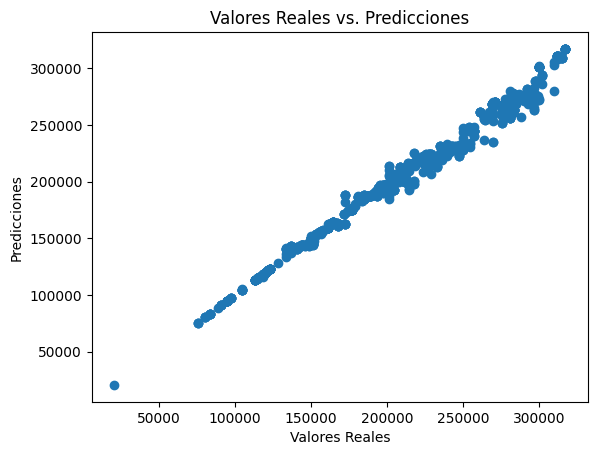

In [142]:
plt.scatter(y_test_filtered, y_pred)  
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Valores Reales vs. Predicciones")
plt.show()

### Ajuste del modelo

In [144]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# Defino los posibles valores de hiperparámetros a probar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Inicializo el modelo con GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,  
    scoring='neg_mean_squared_error',  
    n_jobs=-1
)



In [145]:
# Entreno el modelo utilizando GridSearchCV
grid_search.fit(X_train_encoded, y_train)

# Obtengo el mejor modelo y los mejores hiperparámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Realizo validación cruzada en el mejor modelo
cv_scores = cross_val_score(best_model, X_train_encoded, y_train, cv=5, scoring='neg_mean_squared_error')



In [146]:
# Calculo la media de los resultados de validación cruzada
cv_mean_mse = -cv_scores.mean()

print("Mejores hiperparámetros:", best_params)
print("Mean Squared Error en validación cruzada:", cv_mean_mse)


Mejores hiperparámetros: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error en validación cruzada: 14219534.576849256


In [147]:
# Evaluo el modelo en el conjunto de prueba
y_pred_best = best_model.predict(X_test_encoded)
mse_best = mean_squared_error(y_test_filtered, y_pred_best)
r2_best = r2_score(y_test_filtered, y_pred_best)

print("Mean Squared Error en conjunto de prueba:", mse_best)
print("R-squared en conjunto de prueba:", r2_best)

Mean Squared Error en conjunto de prueba: 14479526.346372668
R-squared en conjunto de prueba: 0.9961533962946352


In [148]:
import joblib

# Guardo el modelo entrenado en un archivo
model_filename = 'random_forest_model.pkl'
joblib.dump(random_forest_model, model_filename)


['random_forest_model.pkl']